In [1]:
import keras
from keras.layers import Input, Dense, Flatten, Conv1D
from keras.models import load_model, Model
import numpy as np
import sys
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from keras.regularizers import l1
from keras.optimizers import Adam
sys.path.insert(0,'../lib')
from train import get_features
from evaluation import makeRoc, learningCurveLoss

Using TensorFlow backend.


In [2]:
from collections import namedtuple
Option = namedtuple("MyStruct", "inputModel inputFile tree config outputDir ")
options = Option(
    inputModel = 'KERAS_conv1d_weights.h5',
    inputFile = '../processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth_0.z',
    tree = 't_allpar_new',
    config = 'train_config_conv1d.yml',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Loading configuration from train_config_conv1d.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_costhetarel',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv1d_model',
 'KerasModelRetrain': 'conv1d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 100}

# Train

In [3]:
X_train_val, X_test, y_train_val, y_test, labels  = get_features(options, yamlConfig)

(5131613,)
('index', 'j_ptfrac', 'j_pt', 'j_eta', 'j_mass', 'j_tau1_b1', 'j_tau2_b1', 'j_tau3_b1', 'j_tau1_b2', 'j_tau2_b2', 'j_tau3_b2', 'j_tau32_b1', 'j_tau32_b2', 'j_zlogz', 'j_c1_b0', 'j_c1_b1', 'j_c1_b2', 'j_c2_b1', 'j_c2_b2', 'j_d2_b1', 'j_d2_b2', 'j_d2_a1_b1', 'j_d2_a1_b2', 'j_m2_b1', 'j_m2_b2', 'j_n2_b1', 'j_n2_b2', 'j_tau1_b1_mmdt', 'j_tau2_b1_mmdt', 'j_tau3_b1_mmdt', 'j_tau1_b2_mmdt', 'j_tau2_b2_mmdt', 'j_tau3_b2_mmdt', 'j_tau32_b1_mmdt', 'j_tau32_b2_mmdt', 'j_c1_b0_mmdt', 'j_c1_b1_mmdt', 'j_c1_b2_mmdt', 'j_c2_b1_mmdt', 'j_c2_b2_mmdt', 'j_d2_b1_mmdt', 'j_d2_b2_mmdt', 'j_d2_a1_b1_mmdt', 'j_d2_a1_b2_mmdt', 'j_m2_b1_mmdt', 'j_m2_b2_mmdt', 'j_n2_b1_mmdt', 'j_n2_b2_mmdt', 'j_mass_trim', 'j_mass_mmdt', 'j_mass_prun', 'j_mass_sdb2', 'j_mass_sdm1', 'j_multiplicity', 'j1_px', 'j1_py', 'j1_pz', 'j1_e', 'j1_pdgid', 'j1_erel', 'j1_pt', 'j1_ptrel', 'j1_eta', 'j1_etarel', 'j1_etarot', 'j1_phi', 'j1_phirel', 'j1_phirot', 'j1_deltaR', 'j1_costheta', 'j1_costhetarel', 'j1_e1mcosthetarel', 'j_

# Self-Build Model

In [4]:
l1Reg = yamlConfig['L1Reg']
Inputs = Input(shape = (100,7))
x = Conv1D(filters= 8, kernel_size=4, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(Inputs)
x = Conv1D(filters= 4, kernel_size=4, strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)
x = Conv1D(filters=2, kernel_size=4, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg))(x)
x = Flatten()(x)
x = Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg))(x)
predictions = Dense(5, activation='softmax', kernel_initializer='lecun_uniform', name='rnn_densef')(x)
model = Model(inputs=Inputs, outputs=predictions)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 7)]          0         
_________________________________________________________________
conv1_relu_1 (Conv1D)        (None, 100, 8)            232       
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 50, 4)             132       
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 17, 2)             34        
_________________________________________________________________
flatten (Flatten)            (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
rnn_densef (Dense)           (None, 5)                 165   

In [5]:
adam = Adam(lr = 0.0001)
model.compile(optimizer=adam, loss=[yamlConfig['KerasLoss']], metrics=['accuracy'])

history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 100, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/100
58/58 [==============================] - 1s 13ms/step - loss: 1.9942 - accuracy: 0.2395 - val_loss: 1.8554 - val_accuracy: 0.2453
Epoch 2/100
58/58 [==============================] - 0s 6ms/step - loss: 1.8027 - accuracy: 0.2407 - val_loss: 1.7373 - val_accuracy: 0.2473
Epoch 3/100
58/58 [==============================] - 0s 6ms/step - loss: 1.7130 - accuracy: 0.2452 - val_loss: 1.6723 - val_accuracy: 0.2539
Epoch 4/100
58/58 [==============================] - 0s 6ms/step - loss: 1.6581 - accuracy: 0.2552 - val_loss: 1.6272 - val_accuracy: 0.2650
Epoch 5/100
58/58 [==============================] - 0s 6ms/step - loss: 1.6163 - accuracy: 0.2668 - val_loss: 1.5894 - val_accuracy: 0.2789
Epoch 6/100
58/58 [==============================] - 0s 6ms/step - loss: 1.5804 - accuracy: 0.2818 - val_loss: 1.5564 - val_accuracy: 0.2940
Epoch 7/100
58/58 [==============================] - 0s 6ms/step - loss: 1.5482 - accuracy: 0.2976 - val_loss: 1.5262 - val_accuracy: 0.3090
Epoch 8/100


# Conv1d Evaluation

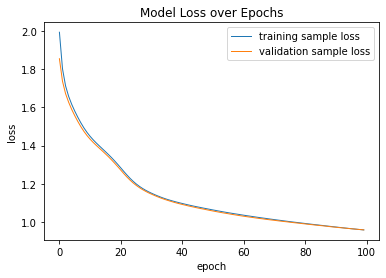

In [6]:
learningCurveLoss(history)

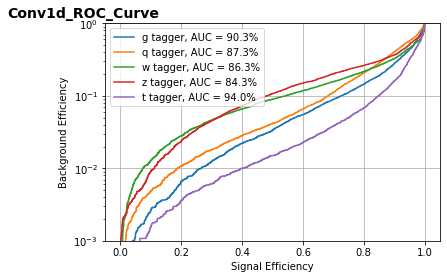

In [7]:
y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='Conv1d')